In [105]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def evaluate_bb_strategy(
            data,
            start = '2020-01-01',
            end   = '2025-01-01',
            sma_window = 50,
            bb_window = 20,
            bb_std = 2,
            buy_fraction = 0.1,
            sell_fraction = 0.1,
            initial_cash = 80_000,
            spy_weight=0.5,
            gld_weight=0.5,
            plot=True,
            ):
    # Compute 50/50 portfolio
    portfolio_price = 0.5*data['SPY'] + 0.5*data['GLD']
    
    # --------------------
    # Bollinger Bands and SMA
    # --------------------
    sma50 = portfolio_price.rolling(sma_window).mean()
    bb_mid = portfolio_price.rolling(bb_window).mean()
    bb_std_series = portfolio_price.rolling(bb_window).std()
    bb_upper = bb_mid + bb_std * bb_std_series
    bb_lower = bb_mid - bb_std * bb_std_series
    
    # --------------------
    # Initialize portfolio
    # --------------------
    cash = initial_cash
    position = 0
    port_value = []
    buy_price = 0
    # Lists to record buy/sell signals
    buy_signals = []
    sell_signals = []
    cash_value = []
    
    # --------------------
    # Strategy loop
    # --------------------
    for i in range(len(portfolio_price)):
        p = portfolio_price.iat[i]  # scalar
        mid = bb_mid.iat[i]         # scalar
        date = portfolio_price.index[i]

        if pd.isna(mid):
            port_value.append(cash + position*p)
            cash_value.append(cash)
            continue
    
        # Gradual buy if below middle band
        if p < mid:
            buy_amount = cash * buy_fraction
            if buy_amount > 0:
                shares_bought = buy_amount / p
                position += shares_bought
                cash -= shares_bought * p
                buy_price = (buy_price*(position-shares_bought) + p*shares_bought)/position
                buy_signals.append((date, p))
    
        # Gradual sell if above middle band and profitable
        elif p > mid and position > 0:
            if p > buy_price:
                shares_to_sell = position * sell_fraction
                cash += shares_to_sell * p
                position -= shares_to_sell
                sell_signals.append((date, p))
        port_value.append(cash + position*p)
        cash_value.append(cash)

  
    # --------------------
    # Portfolio as Series
    # --------------------
    portfolio = pd.Series(port_value, index=portfolio_price.index)
    cash_series = pd.Series(cash_value, index=portfolio_price.index)
    
    # --------------------
    # Plot
    # --------------------
    # Plot
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(portfolio, label='Strategy Portfolio (50/50 SPY+GLD)')
        # plt.plot(portfolio_price/portfolio_price.iloc[0]*initial_cash, label='Buy & Hold 50/50')
        plt.plot(cash_series, label="cash")
        # # Plot buy signals
        # if buy_signals:
        #     buy_dates, buy_prices = zip(*buy_signals)
        #     plt.scatter(buy_dates, [initial_cash/portfolio_price.iloc[0]*p for p in buy_prices],
        #                 marker='^', color='green', s=50, label='Buy')
        
        # # Plot sell signals
        # if sell_signals:
        #     sell_dates, sell_prices = zip(*sell_signals)
        #     plt.scatter(sell_dates, [initial_cash/portfolio_price.iloc[0]*p for p in sell_prices],
        #                 marker='v', color='red', s=50, label='Sell')
        
        plt.title("50/50 SPY+GLD Bollinger + SMA50 Gradual Buy/Sell Strategy")
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    # --------------------
    # Performance Metrics
    # --------------------
    port_ret = portfolio.pct_change().dropna()
    buyhold_ret = portfolio_price.pct_change().dropna()
    
    # Annualized Return
    n_days = len(port_ret)
    annual_return = (portfolio.iloc[-1]/portfolio.iloc[0])**(252/n_days) - 1
    
    # Annualized Volatility
    annual_vol = port_ret.std() * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe = (port_ret.mean() / port_ret.std()) * np.sqrt(252)
    
    # Max Drawdown
    cum_max = portfolio.cummax()
    drawdown = (portfolio - cum_max) / cum_max
    max_drawdown = drawdown.min()
    
    # Alpha & Beta vs 50/50 Buy & Hold
    cov = np.cov(port_ret, buyhold_ret)
    beta = cov[0,1] / cov[1,1]
    alpha_daily = port_ret.mean() - beta * buyhold_ret.mean()
    alpha_annual = alpha_daily * 252
    
    performance_metrics = {
        "annualized_return": f"{annual_return:.2%}",
        "annualized_volatility": f"{annual_vol:.2%}",
        "sharpe_ratio": f"{sharpe:.2f}",
        "max_drawdown": f"{max_drawdown:.2%}",
        "beta_vs_50_50_buy_hold": f"{beta:.2f}",
        "alpha_vs_50_50_buy_hold_annualized": f"{alpha_annual:.2%}"
    }


    return performance_metrics

/tmp/ipykernel_202/23451579.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close'].ffill()
[*********************100%***********************]  2 of 2 completed


/tmp/ipykernel_202/3776824045.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close'].ffill()
[*********************100%***********************]  2 of 2 completed
/tmp/ipykernel_202/281738953.py:106: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = (port_ret.mean() / port_ret.std()) * np.sqrt(252)


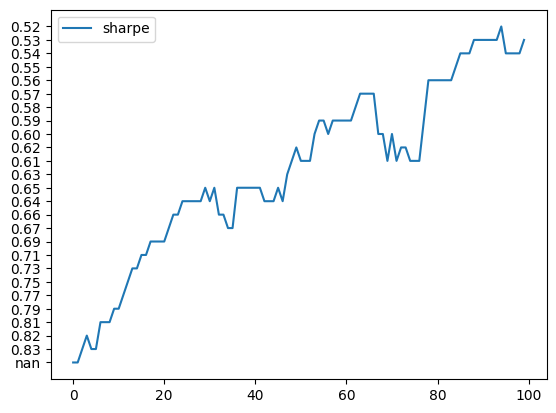

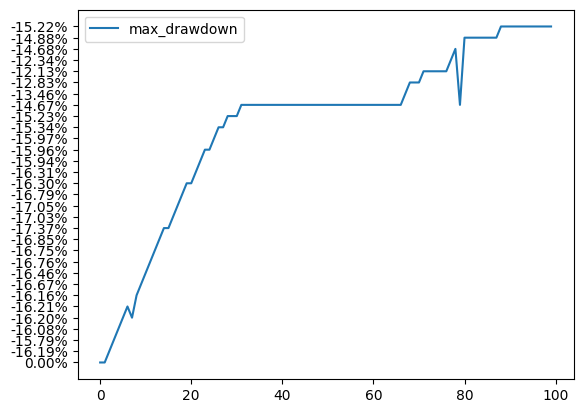

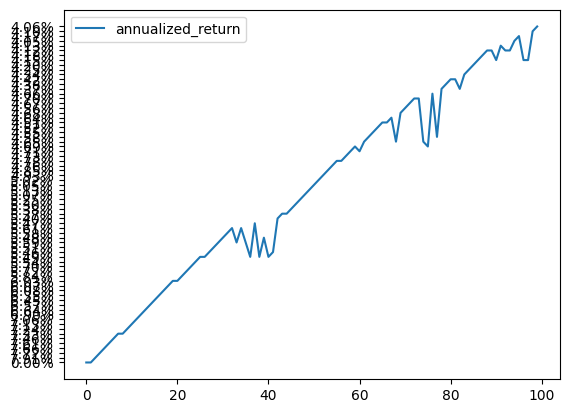

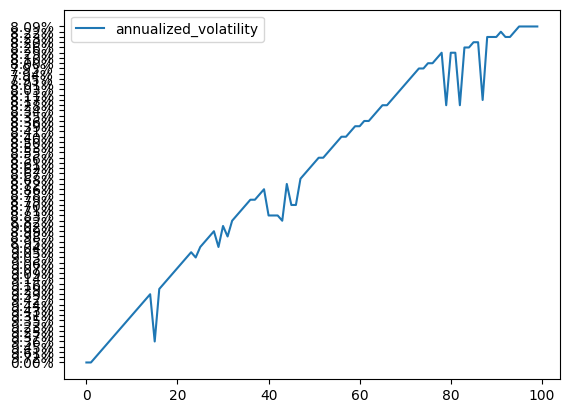

In [42]:
# def evaluate_bb_strategy(
#             data,
#             start = '2020-01-01',
#             end   = '2025-01-01',
#             sma_window = 50,
#             bb_window = 20,
#             bb_std = 2,
#             buy_fraction = 0.1,
#             sell_fraction = 0.1,
#             initial_cash = 80_000,
#             spy_weight=0.5,
#             gld_weight=0.5
#             ):

# evaluate_bb_strategy(data)


# evaluate_bb_strategy(data)
# Annualized Return: 6.57%
# Annualized Volatility: 11.26%
# Sharpe Ratio: 0.62
# Max Drawdown: -16.30%
# Beta vs 50/50 Buy & Hold: 0.64
# Alpha vs 50/50 Buy & Hold (annualized): -1.70%

# evaluate_bb_strategy(data, bb_window=50)
# Annualized Return: 7.68%
# Annualized Volatility: 8.40%
# Sharpe Ratio: 0.92
# Max Drawdown: -10.71%
# Beta vs 50/50 Buy & Hold: 0.39
# Alpha vs 50/50 Buy & Hold (annualized): 2.45%


tickers = ['SPY','GLD']
start = "2015-01-01"
end = '2025-08-23'

data = yf.download(tickers, start=start, end=end)['Close'].ffill()

my_range = range(0,100,1)
sharpe_list = []
max_drawdown_list = []
annual_return_list = []
annualized_volatility_list = []
for i in my_range:
    portfolio_stats = evaluate_bb_strategy(data, bb_window=i, plot=False, start=start,  end=end)
    sharpe_list.append(portfolio_stats["sharpe_ratio"])
    max_drawdown_list.append(portfolio_stats["max_drawdown"])
    annual_return_list.append(portfolio_stats["annualized_return"])
    annualized_volatility_list.append(portfolio_stats["annualized_volatility"])
    
plt.figure()
plt.plot(my_range, sharpe_list, label="sharpe")
plt.legend()
plt.figure()
plt.plot(my_range, max_drawdown_list, label="max_drawdown")
plt.legend()

plt.figure()
plt.plot(my_range, annual_return_list, label="annualized_return")
plt.legend()

plt.figure()
plt.plot(my_range, annualized_volatility_list, label="annualized_volatility")
plt.legend()

/tmp/ipykernel_202/1724086159.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close'].ffill()
[*********************100%***********************]  2 of 2 completed


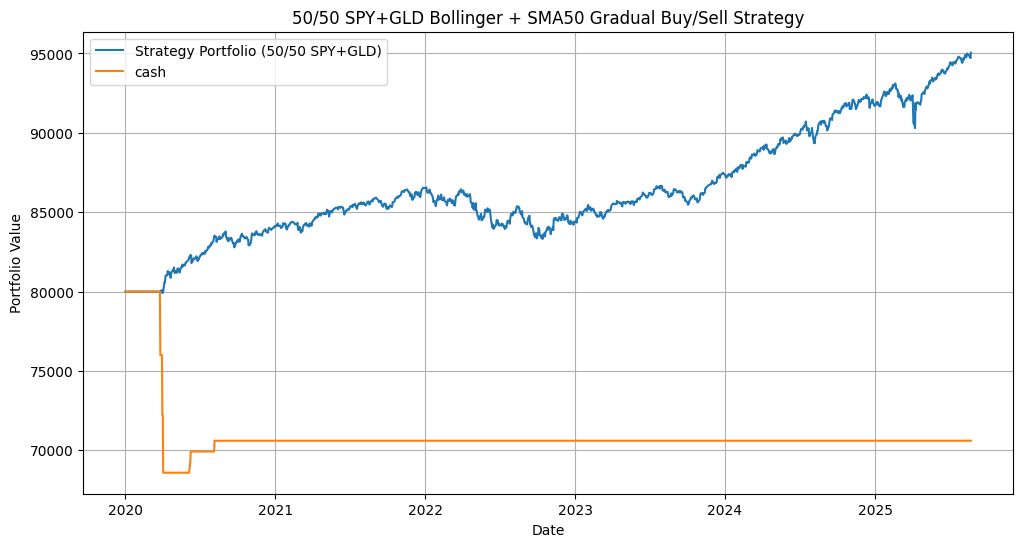

{'annualized_return': '3.11%',
 'annualized_volatility': '2.48%',
 'sharpe_ratio': '1.25',
 'max_drawdown': '-3.74%',
 'beta_vs_50_50_buy_hold': '0.14',
 'alpha_vs_50_50_buy_hold_annualized': '1.07%'}

In [104]:
# def evaluate_bb_strategy(
#             data,
#             start = '2020-01-01',
#             end   = '2025-01-01',
#             sma_window = 50,
#             bb_window = 20,
#             bb_std = 2,
#             buy_fraction = 0.1,
#             sell_fraction = 0.1,
#             initial_cash = 80_000,
#             spy_weight=0.5,
#             gld_weight=0.5
#             ):
tickers = ['SPY','GLD']
start = "2020-01-01"
end = '2025-08-23'

data = yf.download(tickers, start=start, end=end)['Close'].ffill()

evaluate_bb_strategy(data, bb_window=60, start=start,  end=end, initial_cash=80000, sell_fraction=0.05, buy_fraction=0.05)

In [ ]:
fdsafd